In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import re
from difflib import SequenceMatcher
from colorama import init, Fore

from IPython.display import Image, display

# Helper Functions

In [2]:
# Get joined keystroke and classification data
def get_df_joined(instance):
    # KEYSTROKE DATA
    # COL 2: 'Keystrokes'
    # COL 1: 'TimeframeStart'
    df_keystrokes = pd.read_csv(f'data/keylogging/{instance}/keystrokes.csv', names=['Keystrokes', 'TimeframeStart'])

    # CLASSIFICATION DATA
    # COL 1: 'Timestamp'
    # COL 3: 'Text'
    # COL 4: 'Target'
    df_classification = pd.read_csv(f'data/keylogging/{instance}/classification.csv')

    # JOINED DATA
    # COL 1: 'Timestamp'
    # COL 2: 'Keystrokes'
    # COL 4: 'Text'
    # COL 5: 'Target'
    # df_joined = df_classification.join(df_keystrokes.set_index('Timestamp'), on='Timestamp')
    df_joined = []
    df_classification_index = 0
    
    for i in range(0, len(df_keystrokes) - 1):
        this_keystrokes_row = df_keystrokes.iloc[i]
        next_keystrokes_row = df_keystrokes.iloc[i + 1]
        classification_row = df_classification.iloc[df_classification_index]
        
        time_classification = classification_row['Timestamp']
        time_start = this_keystrokes_row['TimeframeStart']
        time_end = next_keystrokes_row['TimeframeStart']
        
        while(time_classification >= time_start and time_classification <= time_end):
            df_joined_row = pd.concat([this_keystrokes_row, classification_row],  axis=0) 
            df_joined.append(df_joined_row)
            
            df_classification_index += 1
            
            if df_classification_index >= len(df_classification):
                break
            
            classification_row = df_classification.iloc[df_classification_index]
            time_classification = classification_row['Timestamp']
            
    df_joined = [i.to_frame().T for i in df_joined]
    df_joined = pd.concat(df_joined, ignore_index=True)
    
    return df_joined

In [3]:
# Cluster subsequent rows where target is the same
def get_df_clustered(df):
    result = [df.iloc[0]]
    
    for i in range(1, len(df)):
        tail = result[-1]
        row = df.iloc[i]
        
        if (tail['Target'] == row['Target']):
            tail['Timestamp'] += ', ' + row['Timestamp']
            
            if not (row['Keystrokes'] in tail['Keystrokes'].split(', ')):
                tail['Keystrokes'] += ', ' + row['Keystrokes']
                
            tail['Text'] += ', ' + row['Text']
        else:
            result.append(row)
            
    for j in range(len(result)):
        row = result[j]
        
        row['Keystrokes'] = ''.join(row['Keystrokes'].split(', '))
        
    return pd.DataFrame(result)

In [4]:
# Finds longest match between keystrokes and text
def find_longest_match(s1, s2, m, n):
    max_len = 0
    end_index = m
   
    find = [[0 for x in range(n + 1)] for y in range(m + 1)]
 
    for i in range(1, m + 1):
        for j in range(1, n + 1):
 
            if s1[i - 1] == s2[j - 1]:
                find[i][j] = find[i - 1][j - 1] + 1
 
                if find[i][j] > max_len:
                    max_len = find[i][j]
                    end_index = i
 
    longest_match = s1[end_index - max_len: end_index]
    
    if len(longest_match) < 4:
        return []
    else:
        return [longest_match]

In [5]:
# Return text with highlights for matched patterns
def highlight_patterns(text, patterns):
    highlights = []
    
    for pattern in patterns:
        text = re.sub(f"({pattern})", Fore.RED + r'\1' + Fore.RESET, text, flags=re.I)
        highlights += re.findall(pattern, text, flags=re.I)

    return text, highlights

In [6]:
# Display an image with a preceding print
def show_image(text, image_name, instance):
    try:
        print(f"{text}Image: {image_name}")
        display(Image(filename=f'data/keylogging/{instance}/images/{image_name}'))
    except FileNotFoundError as e:
        print(e)
        print(f"Could not find {image_name}\n")

In [7]:
# Pretty print the clustered dataframe
def pprint(df, instance, patterns):
    for i in range(len(df)):
        print("=" * 127 + "\n")
        row = df.iloc[i]
        
        if i == len(df) - 1:
            start_timeframe = row['TimeframeStart']
            print(f"Timeframe: {start_timeframe} - (...)\n")
        else:
            start_timeframe = row['TimeframeStart']
            end_timeframe = df.iloc[i + 1]['TimeframeStart']
            print(f"Timeframe: {start_timeframe} - {end_timeframe}\n")
        
        target = row['Target']
        
        if (target == 0):
            print("Found: Nothing of Interest\n")
        else:
            if (target == 1):
                print("Found: Login Page\n")
            
            if (target == 2): # Else
                print("Found: Credit Card Page\n")
            
            image_names = row['Timestamp'].split(', ')
            
            if len(image_names) == 1:
                image_name = image_names[0]
                show_image("", f"{image_name}.png", instance)
            if len(image_names) > 1:
                image_name_start = image_names[0]
                image_name_end = image_names[-1]
                show_image("Start ", f"{image_name_start}.png", instance)
                show_image("End ", f"{image_name_end}.png", instance)
            
            keystrokes = row['Keystrokes']
            text = row['Text']
            
            keystrokes_processed = re.sub("[\[].*?[\]]", "", keystrokes)
            
            patterns += find_longest_match(keystrokes_processed, text, len(keystrokes_processed), len(text))
            keystrokes_highlighted, highlights = highlight_patterns(keystrokes, patterns)
            
            print(f"Keystrokes: \n{keystrokes_highlighted}")
            print(f"Highlights: \n{highlights}\n")

In [8]:
# Give summary of classification alongside keystrokes and highlights
def summarize(instance, patterns):
    try:
        df_joined = get_df_joined(instance)
        df_clustered = get_df_clustered(df_joined)
        pprint(df_clustered, instance, patterns)
    except FileNotFoundError:
        print("Error: Could not find file")

# Summarize Instances


Timeframe: 2022-06-19-11-34-04 - 2022-06-19-11-34-04

Found: Nothing of Interest


Timeframe: 2022-06-19-11-34-04 - 2022-06-19-11-34-49

Found: Login Page

Start Image: 2022-06-19-11-34-38.png


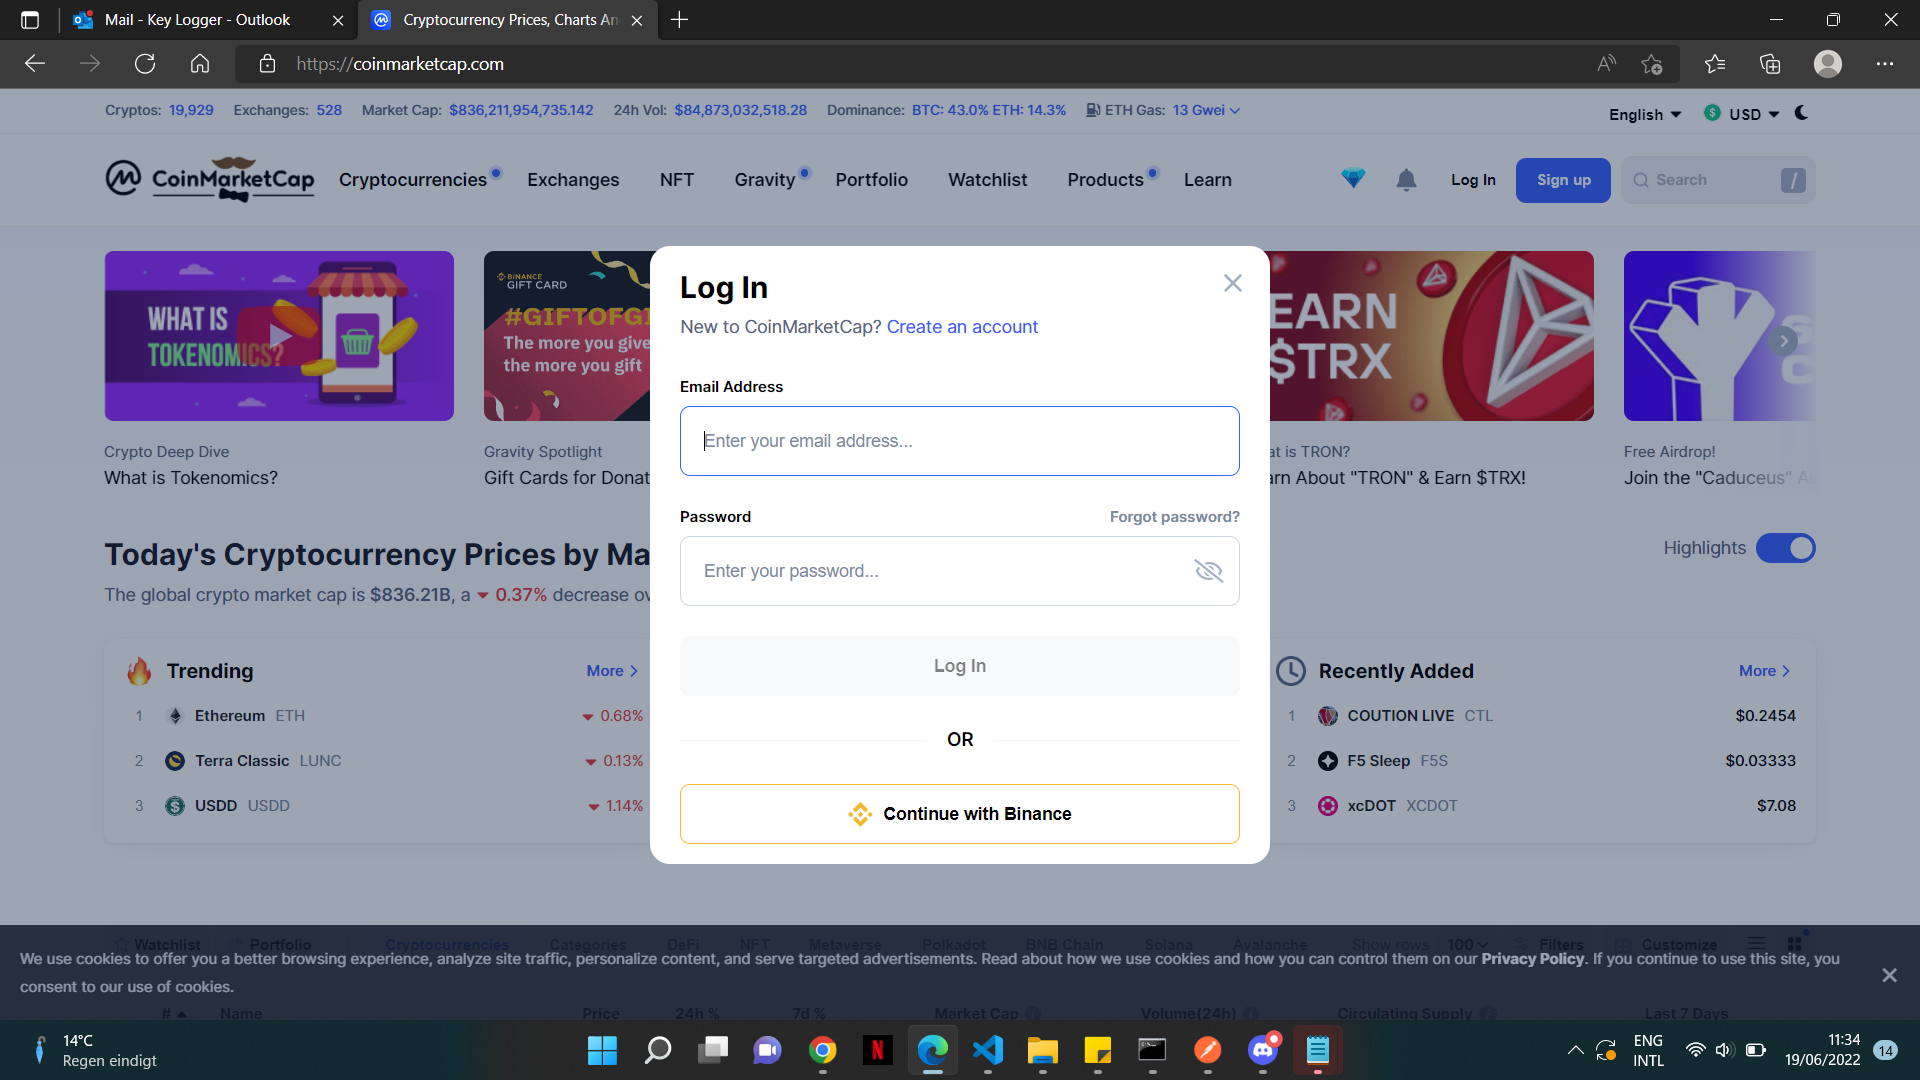

End Image: 2022-06-19-11-35-09.png


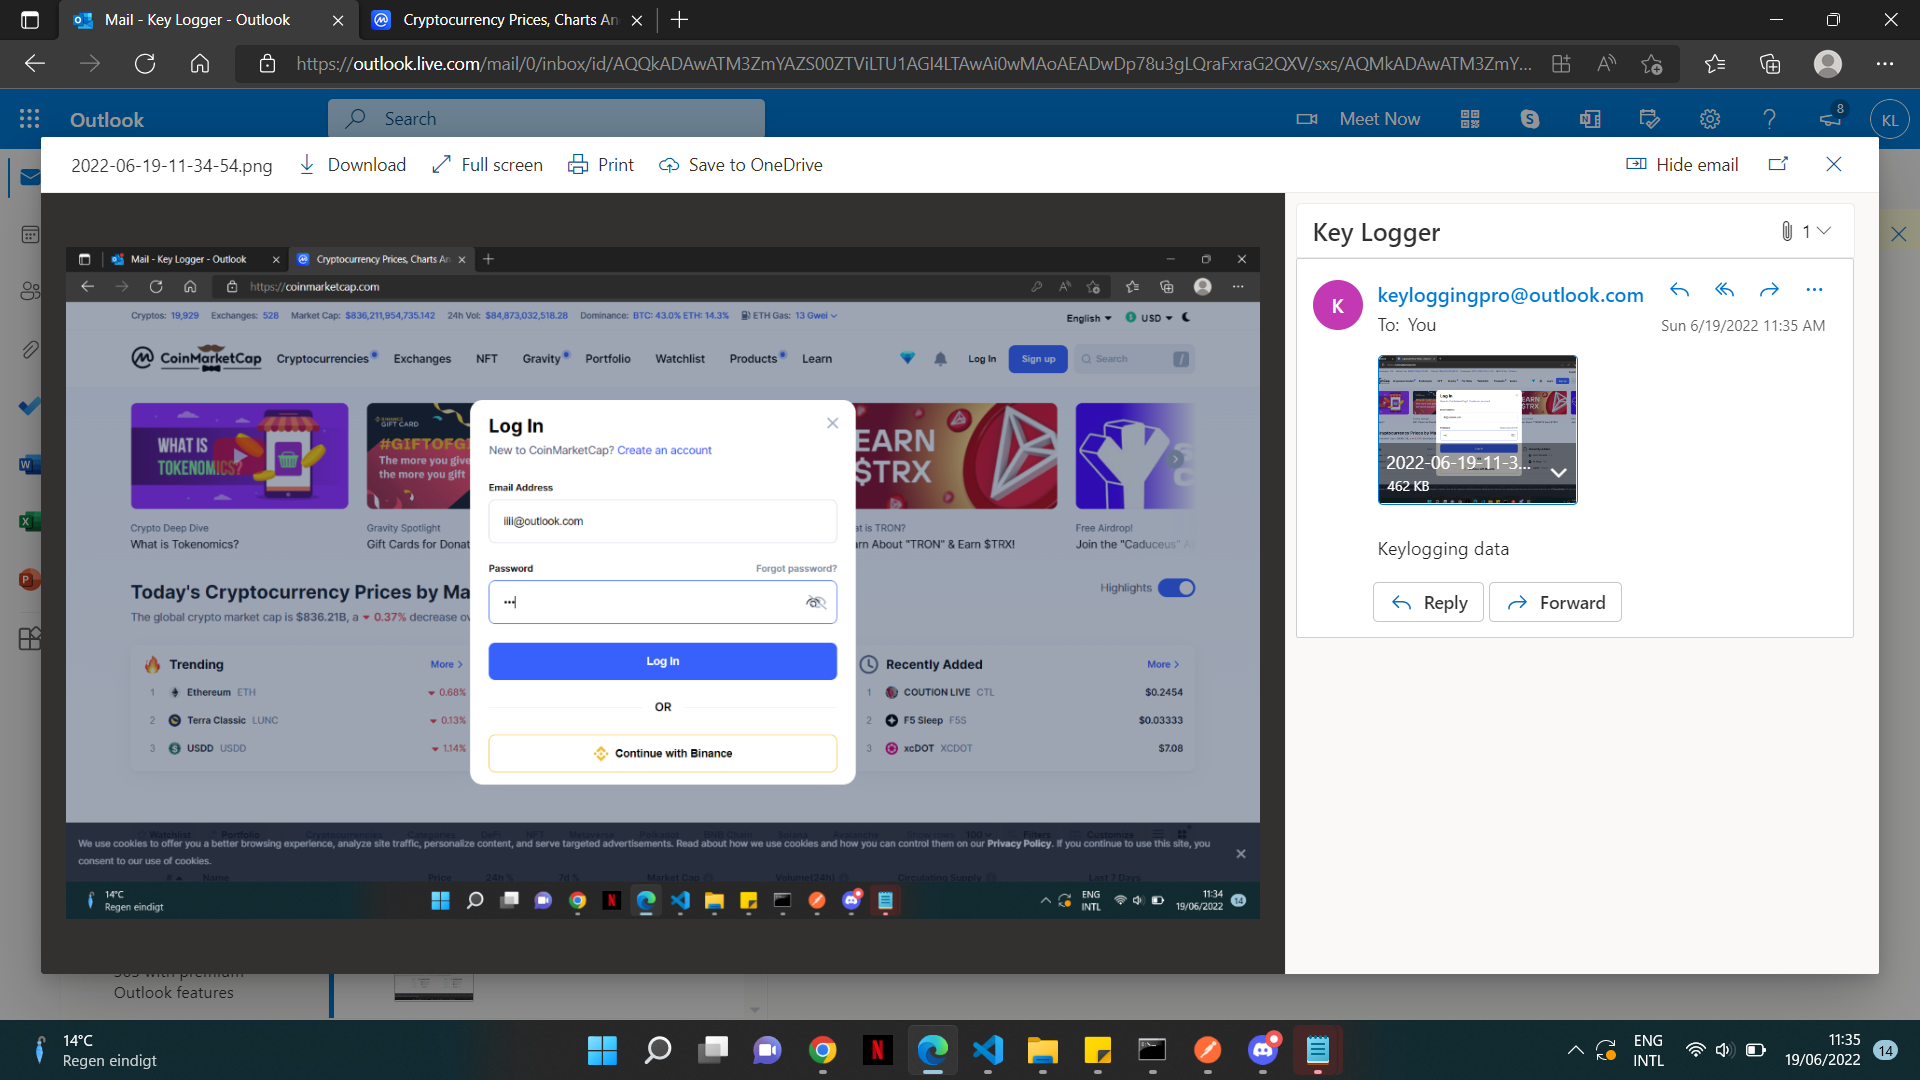

Keystrokes: 
eep execi[backspace]uting this till it runs por[backspace][backspace]roperly withou[backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace][backspace]ing[enter]cryptocurrency[enter]i
Highlights: 
['currency']


Timeframe: 2022-06-19-11-34-49 - 2022-06-19-11-35-16

Found: Nothing of Interest


Timeframe: 2022-06-19-11-35-16 - 2022-06-19-11-35-57

Found: Credit Card Page

Start Image: 2022-06-19-11-35-50.png


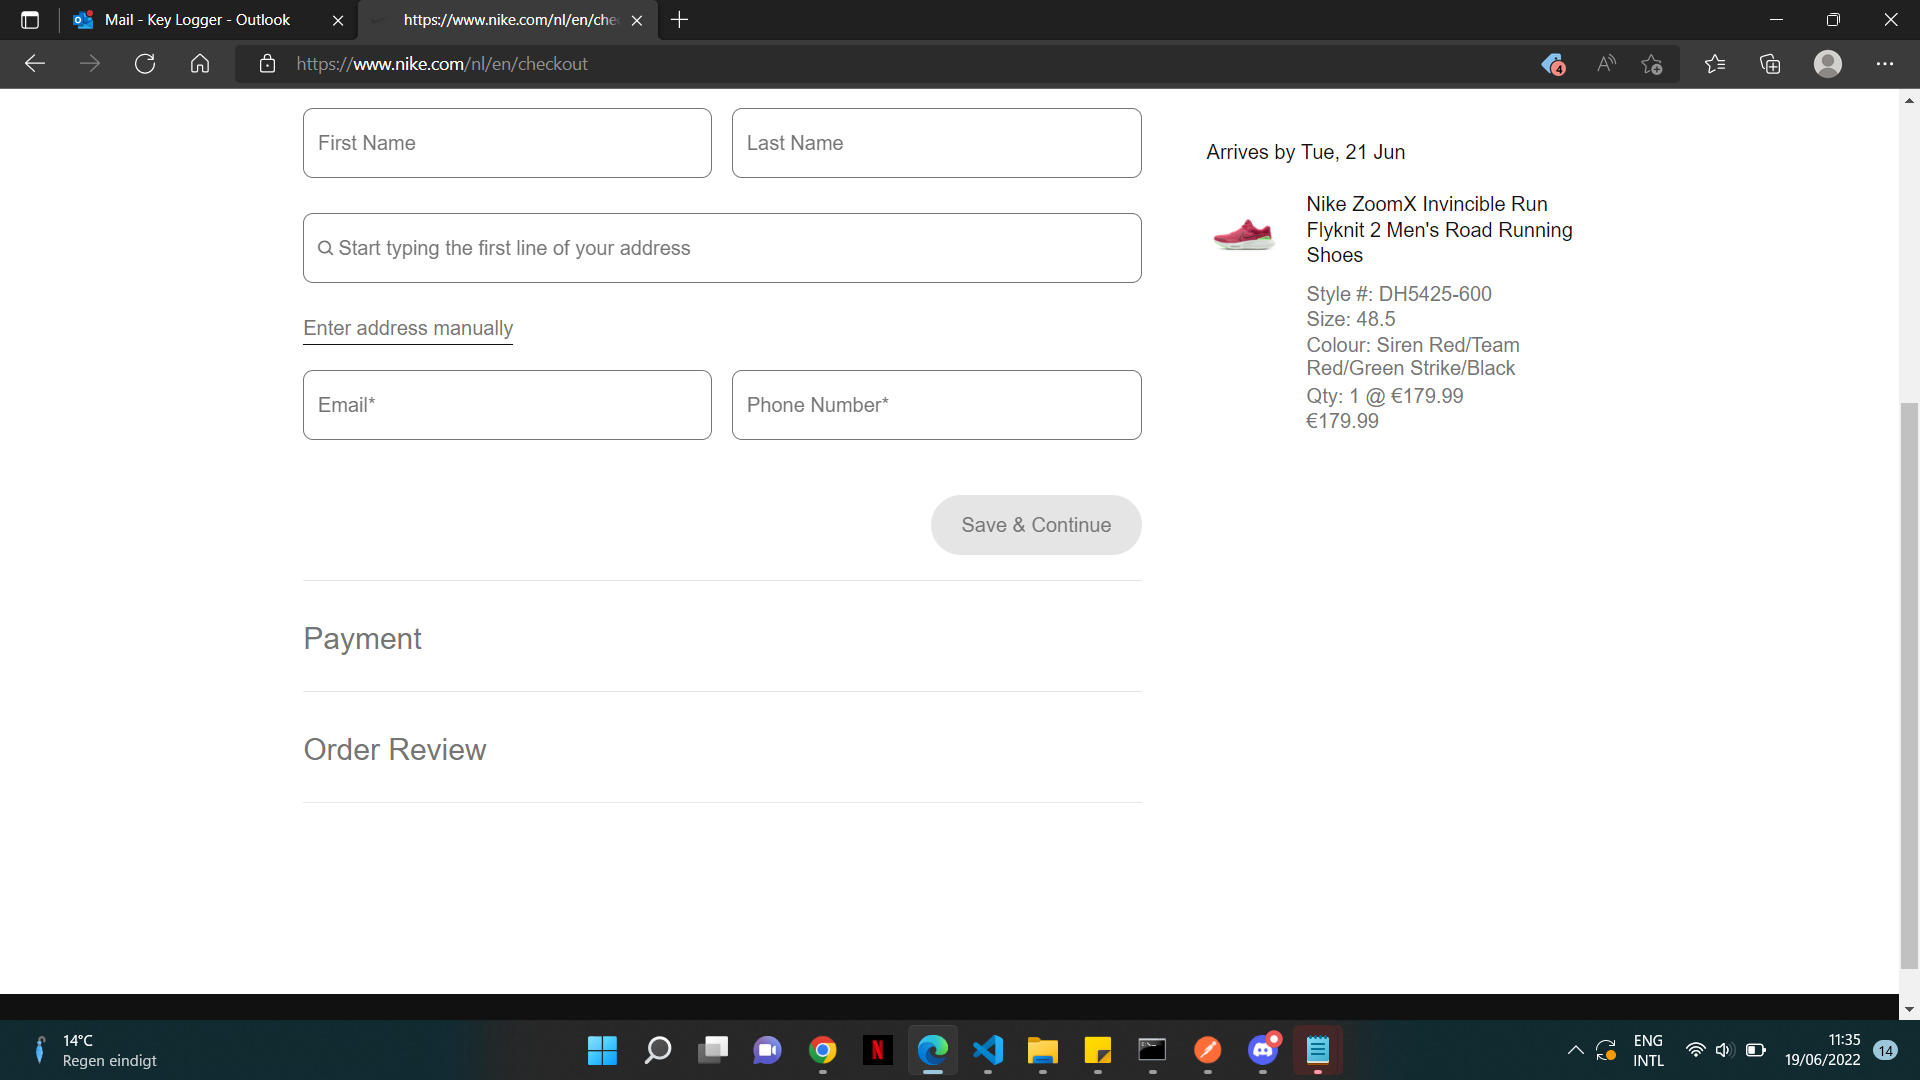

End Image: 2022-06-19-11-35-56.png


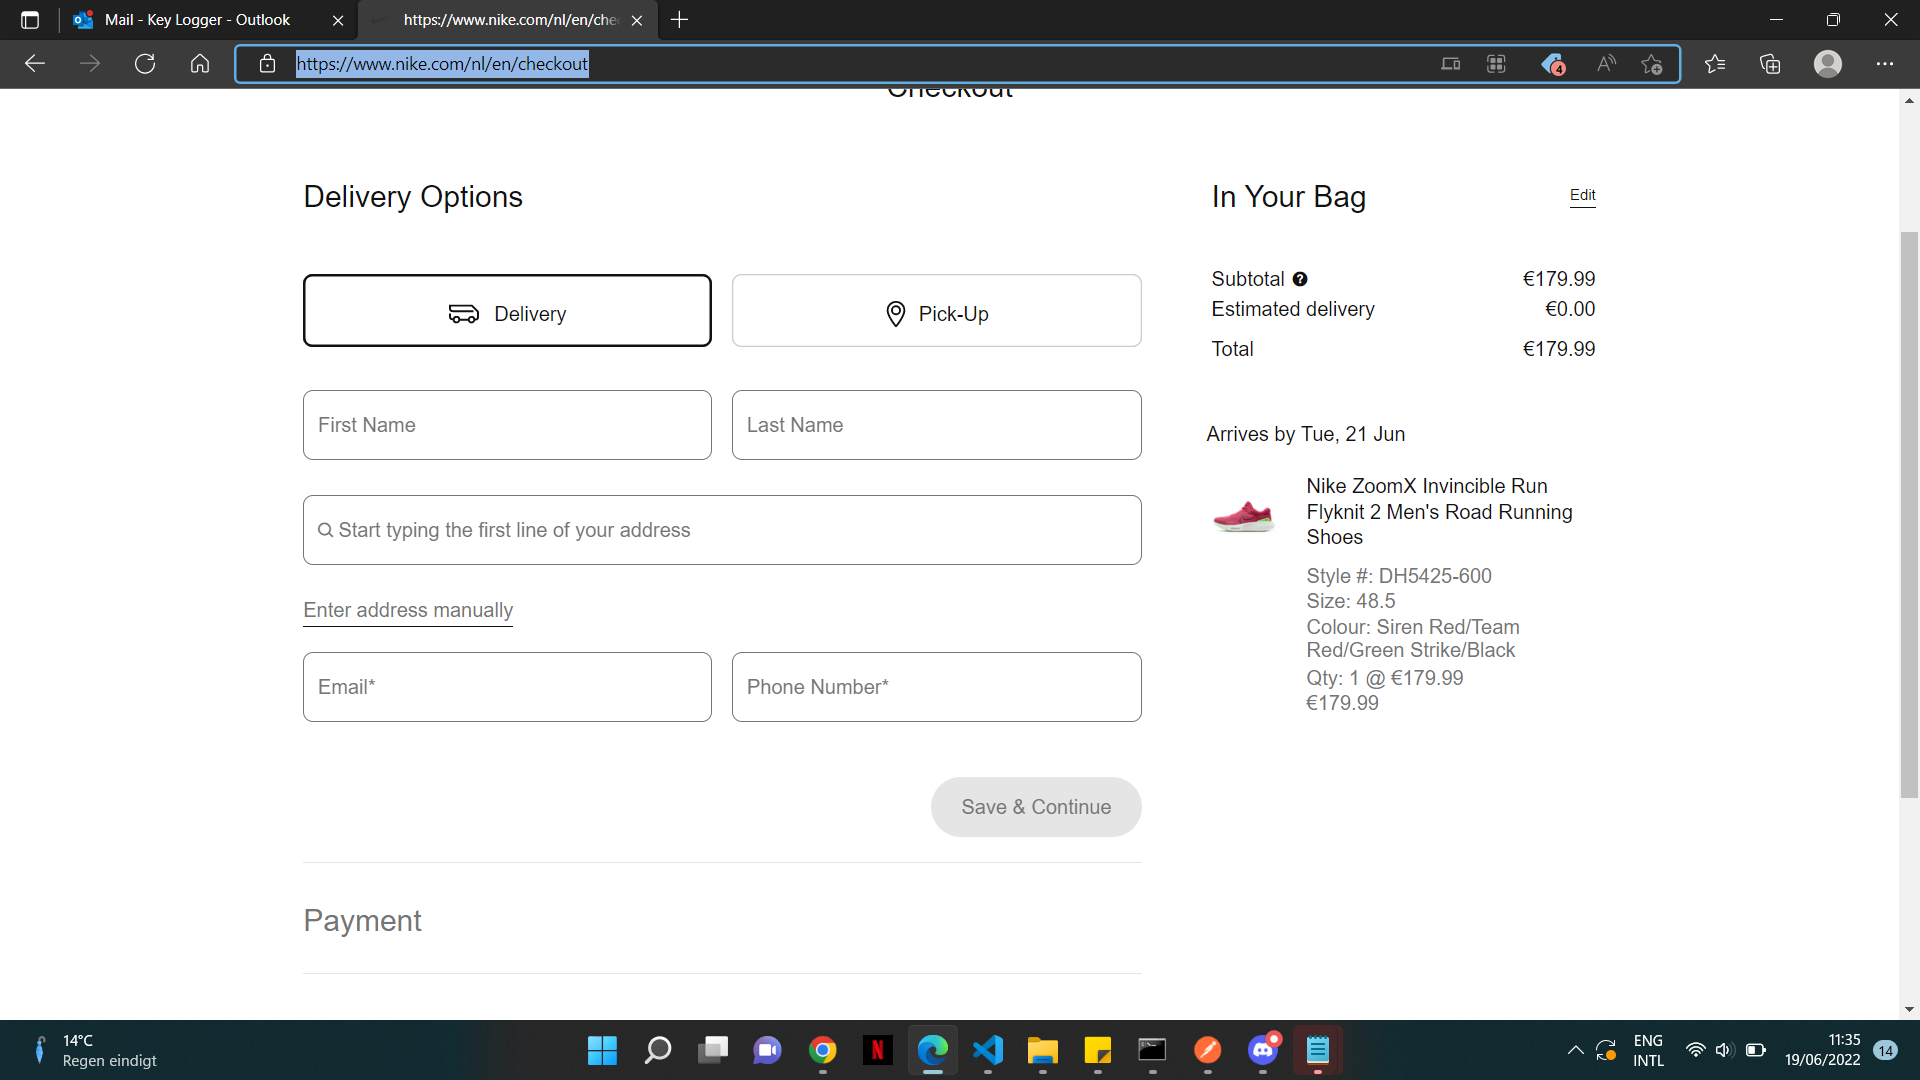

Keystrokes: 
iii@outlook.compassword123n
Highlights: 
['utlook']


Timeframe: 2022-06-19-11-35-57 - 2022-06-19-11-35-57

Found: Nothing of Interest


Timeframe: 2022-06-19-11-35-57 - 2022-06-19-11-36-33

Found: Login Page

Image: 2022-06-19-11-36-09.png


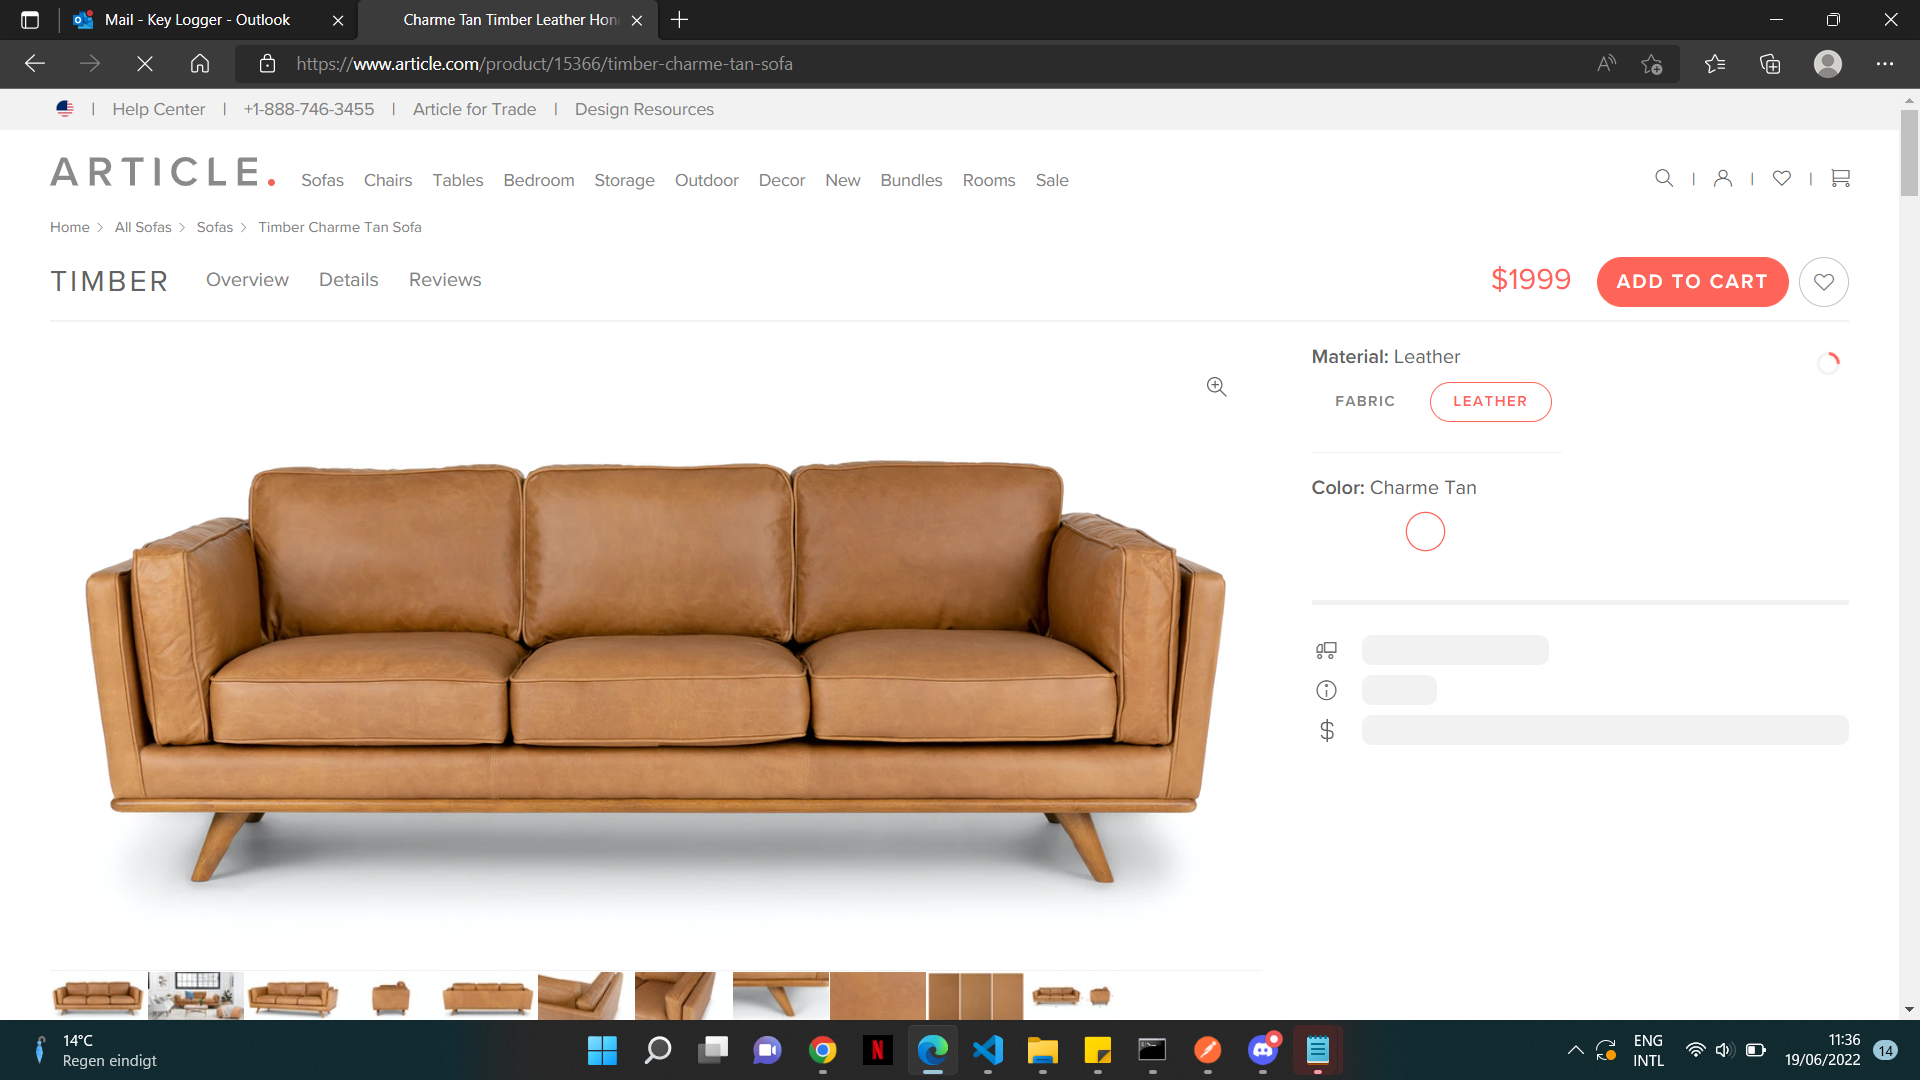

Keystrokes: 
ike.com[enter]a
Highlights: 
['e.com']


Timeframe: 2022-06-19-11-36-33 - 2022-06-19-11-36-33

Found: Credit Card Page

Image: 2022-06-19-11-36-35.png


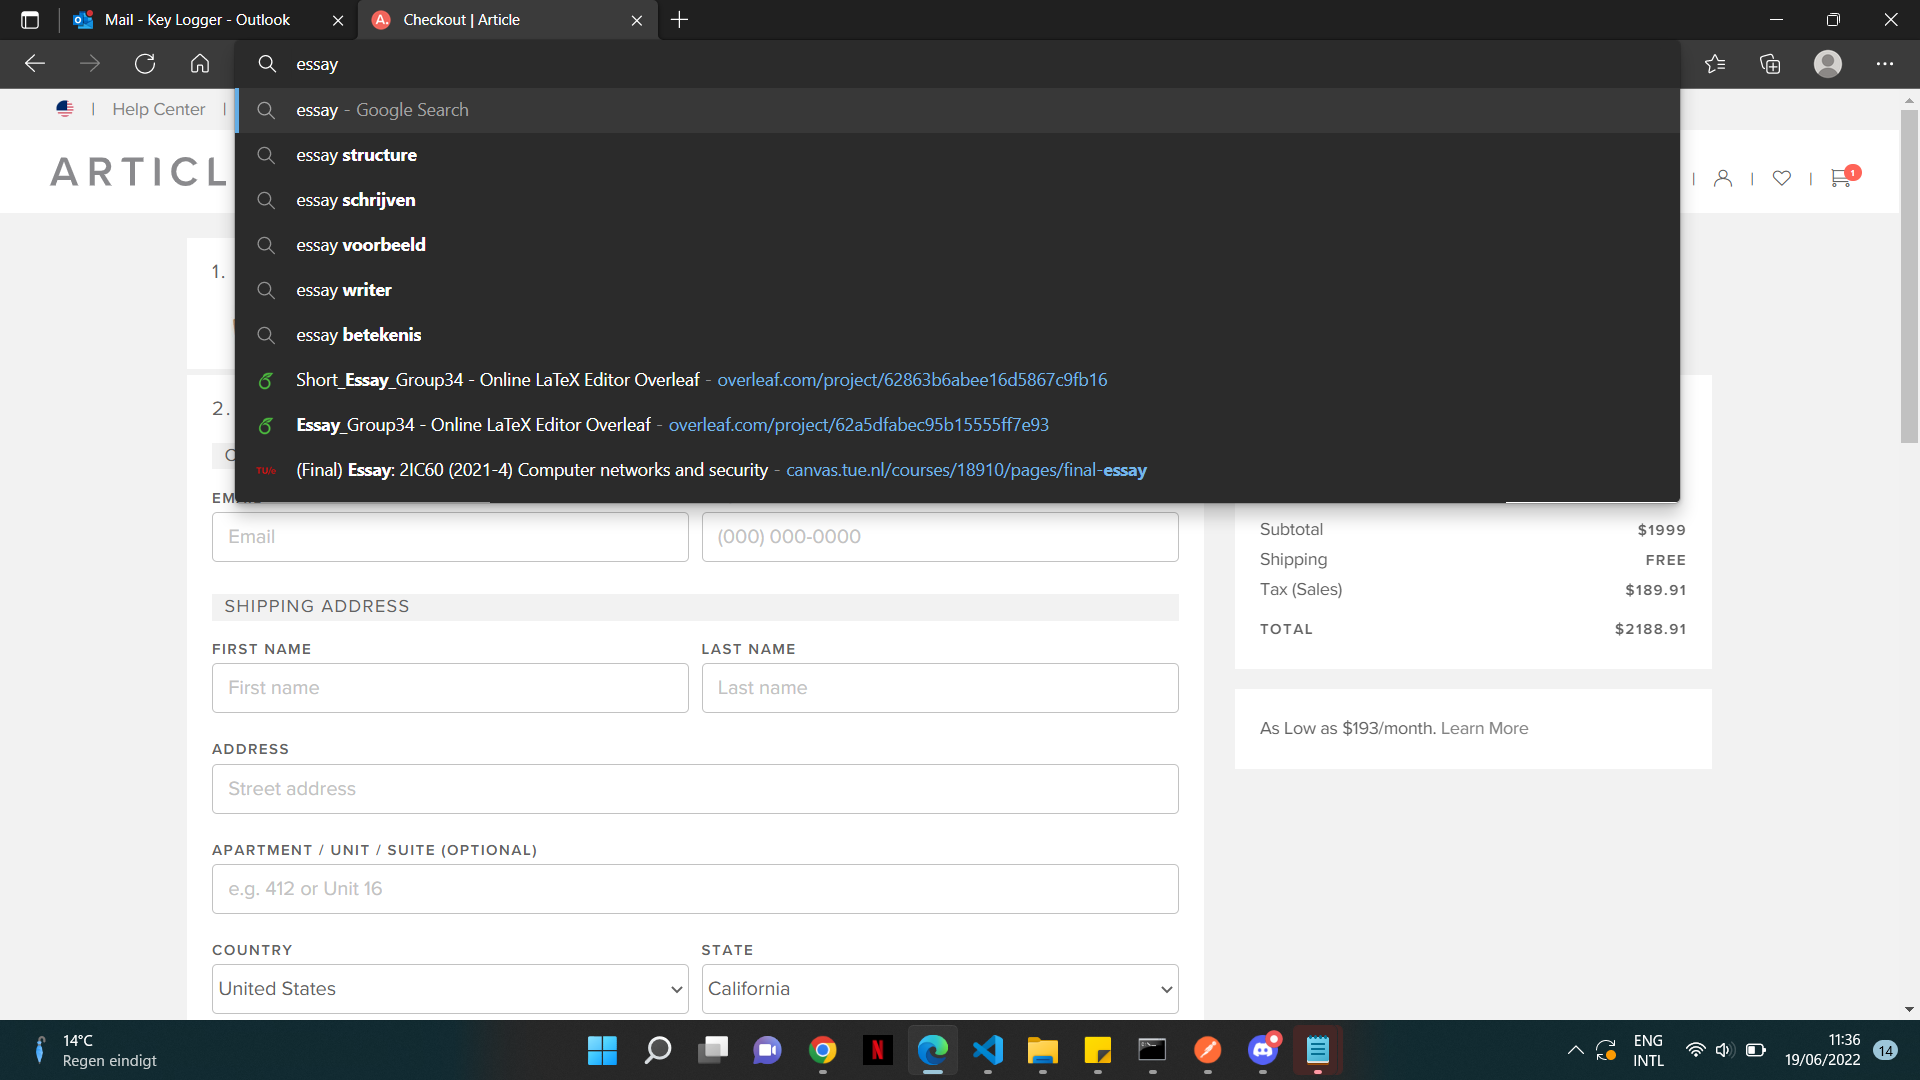

Keystrokes: 
rticle[enter]e
Highlights: 
['rticle']


Timeframe: 2022-06-19-11-36-33 - 2022-06-19-11-37-02

Found: Nothing of Interest


Timeframe: 2022-06-19-11-37-02 - 2022-06-19-11-37-42

Found: Credit Card Page

Start Image: 2022-06-19-11-37-32.png


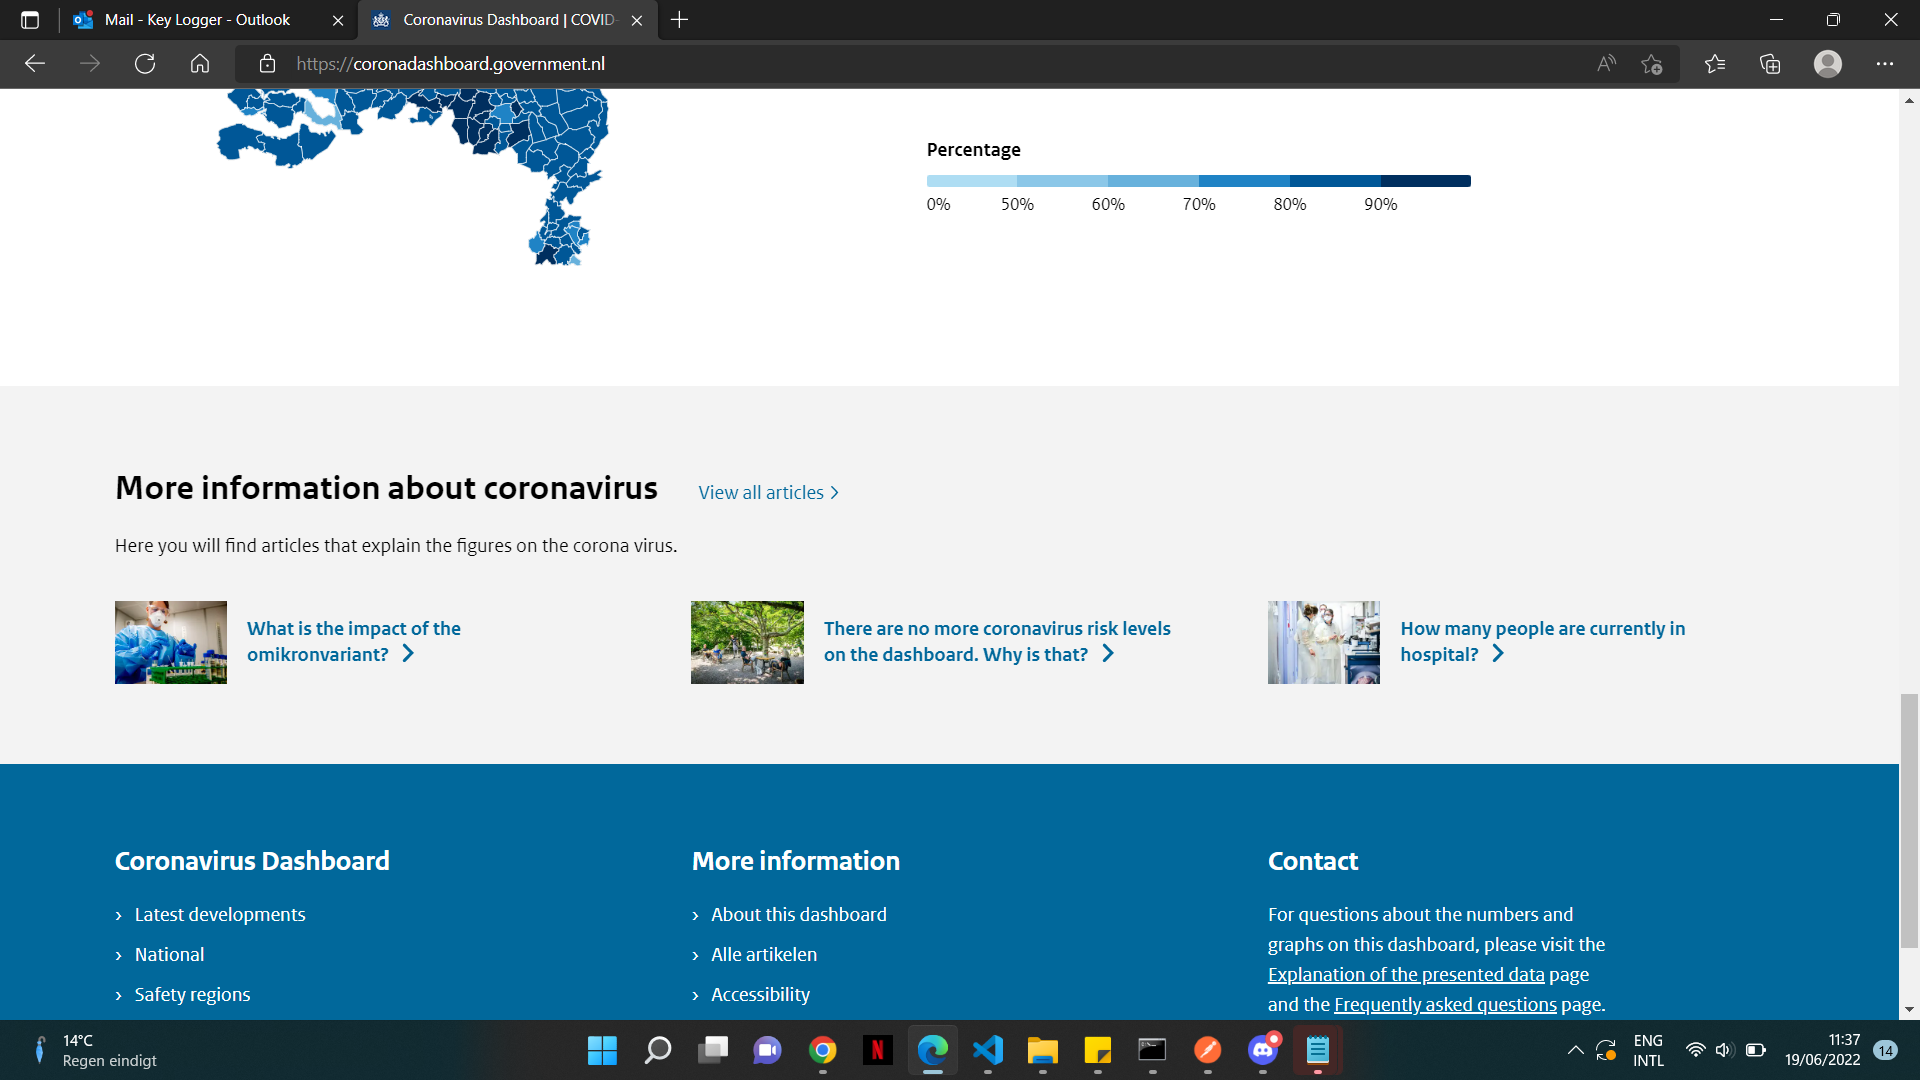

End Image: 2022-06-19-11-37-51.png


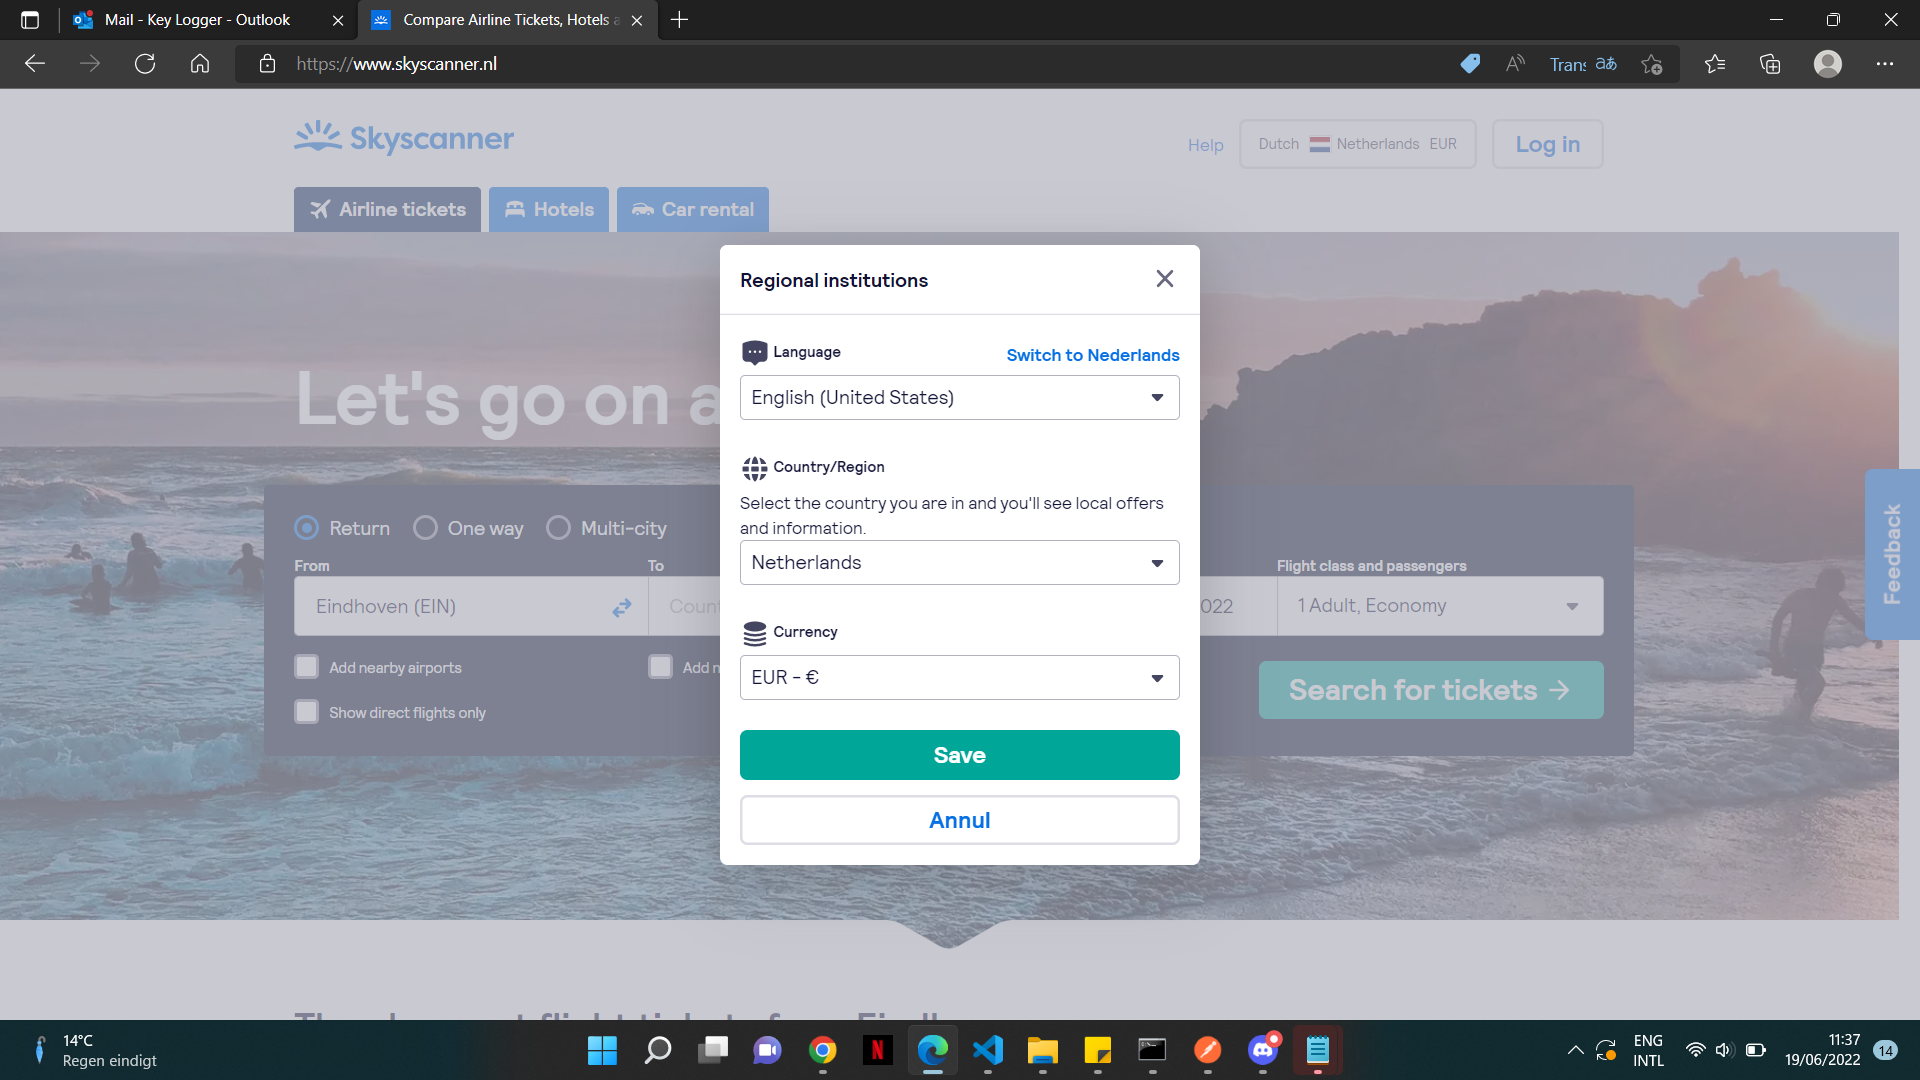

Keystrokes: 
ssay on [enter]cvid 19 cases[enter]s
Highlights: 
[' on ']


Timeframe: 2022-06-19-11-37-42 - 2022-06-19-11-39-03

Found: Nothing of Interest


Timeframe: 2022-06-19-11-39-03 - 2022-06-19-11-39-03

Found: Credit Card Page

Image: 2022-06-19-11-39-13.png


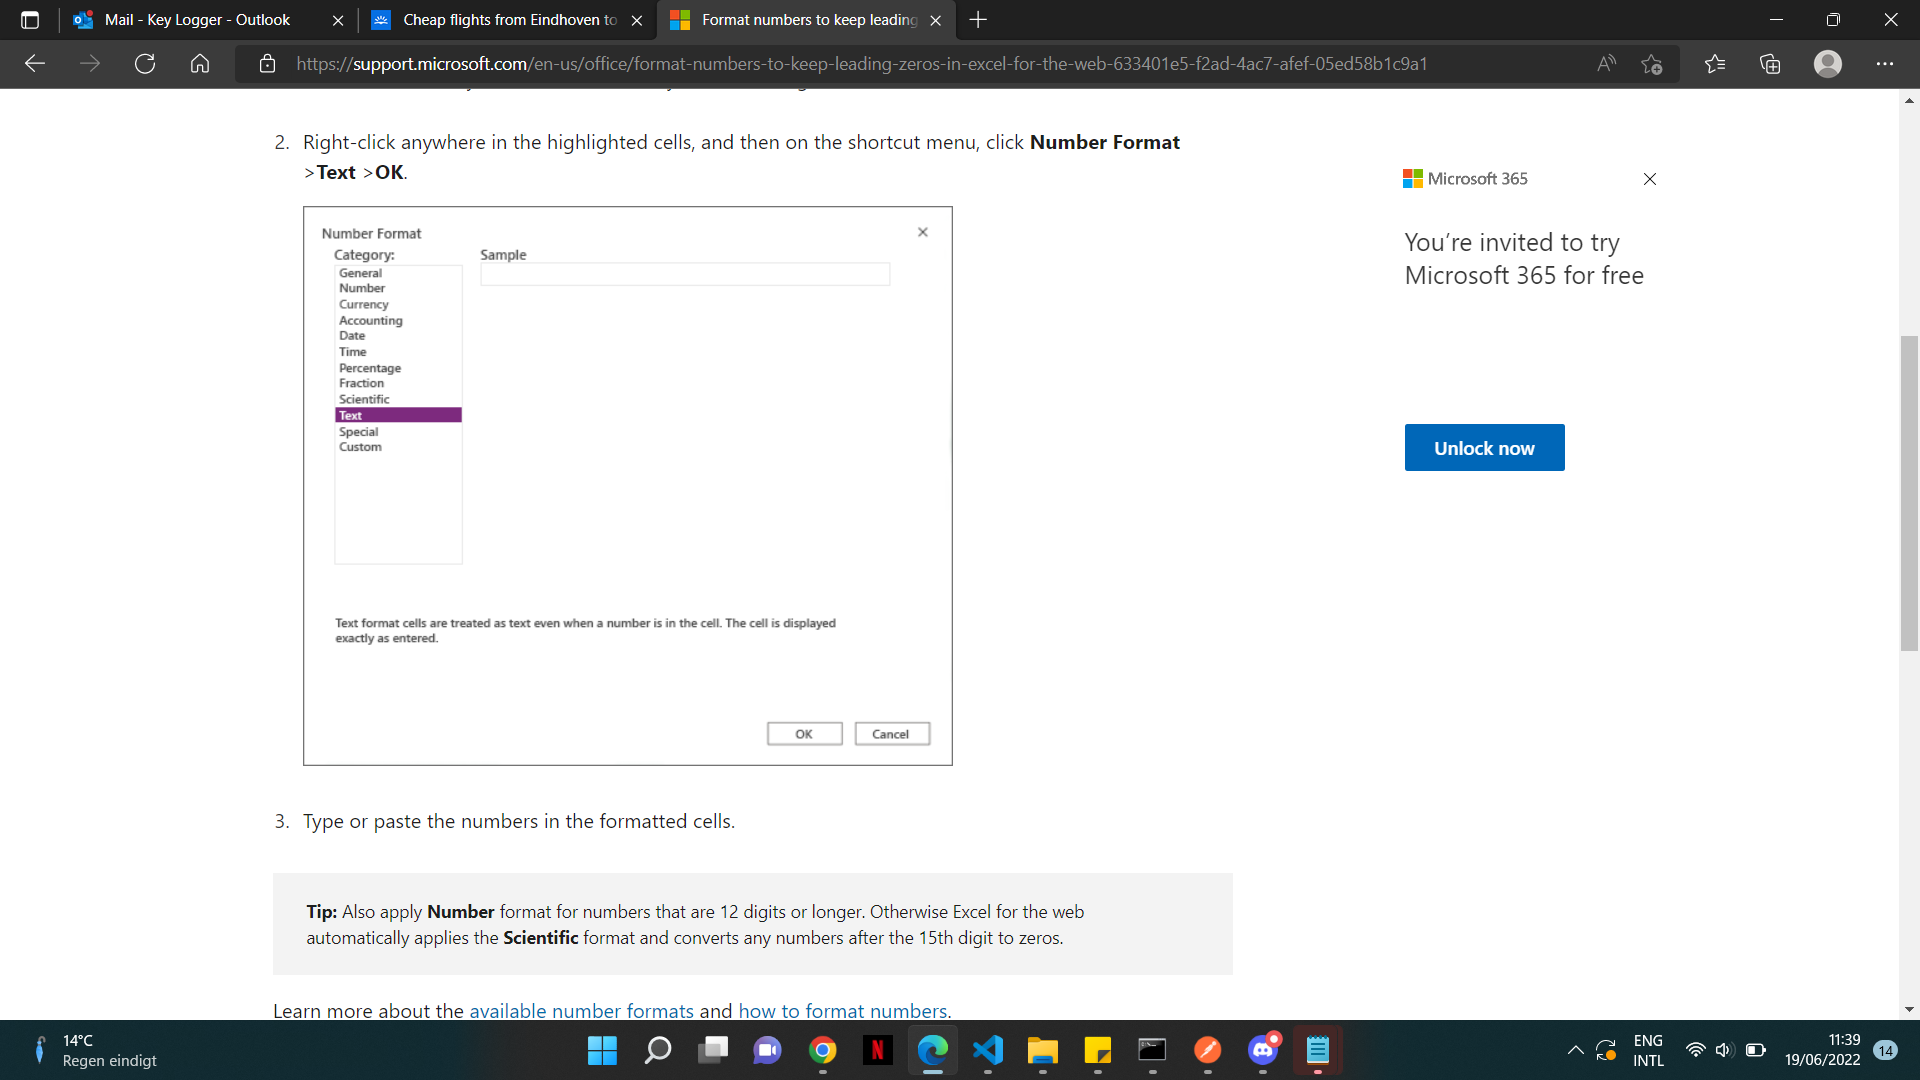

Keystrokes: 
kyscanner[enter]ke
Highlights: 
[]


Timeframe: 2022-06-19-11-39-03 - 2022-06-19-11-39-24

Found: Nothing of Interest


Timeframe: 2022-06-19-11-39-24 - 2022-06-19-11-39-59

Found: Login Page

Start Image: 2022-06-19-11-39-28.png


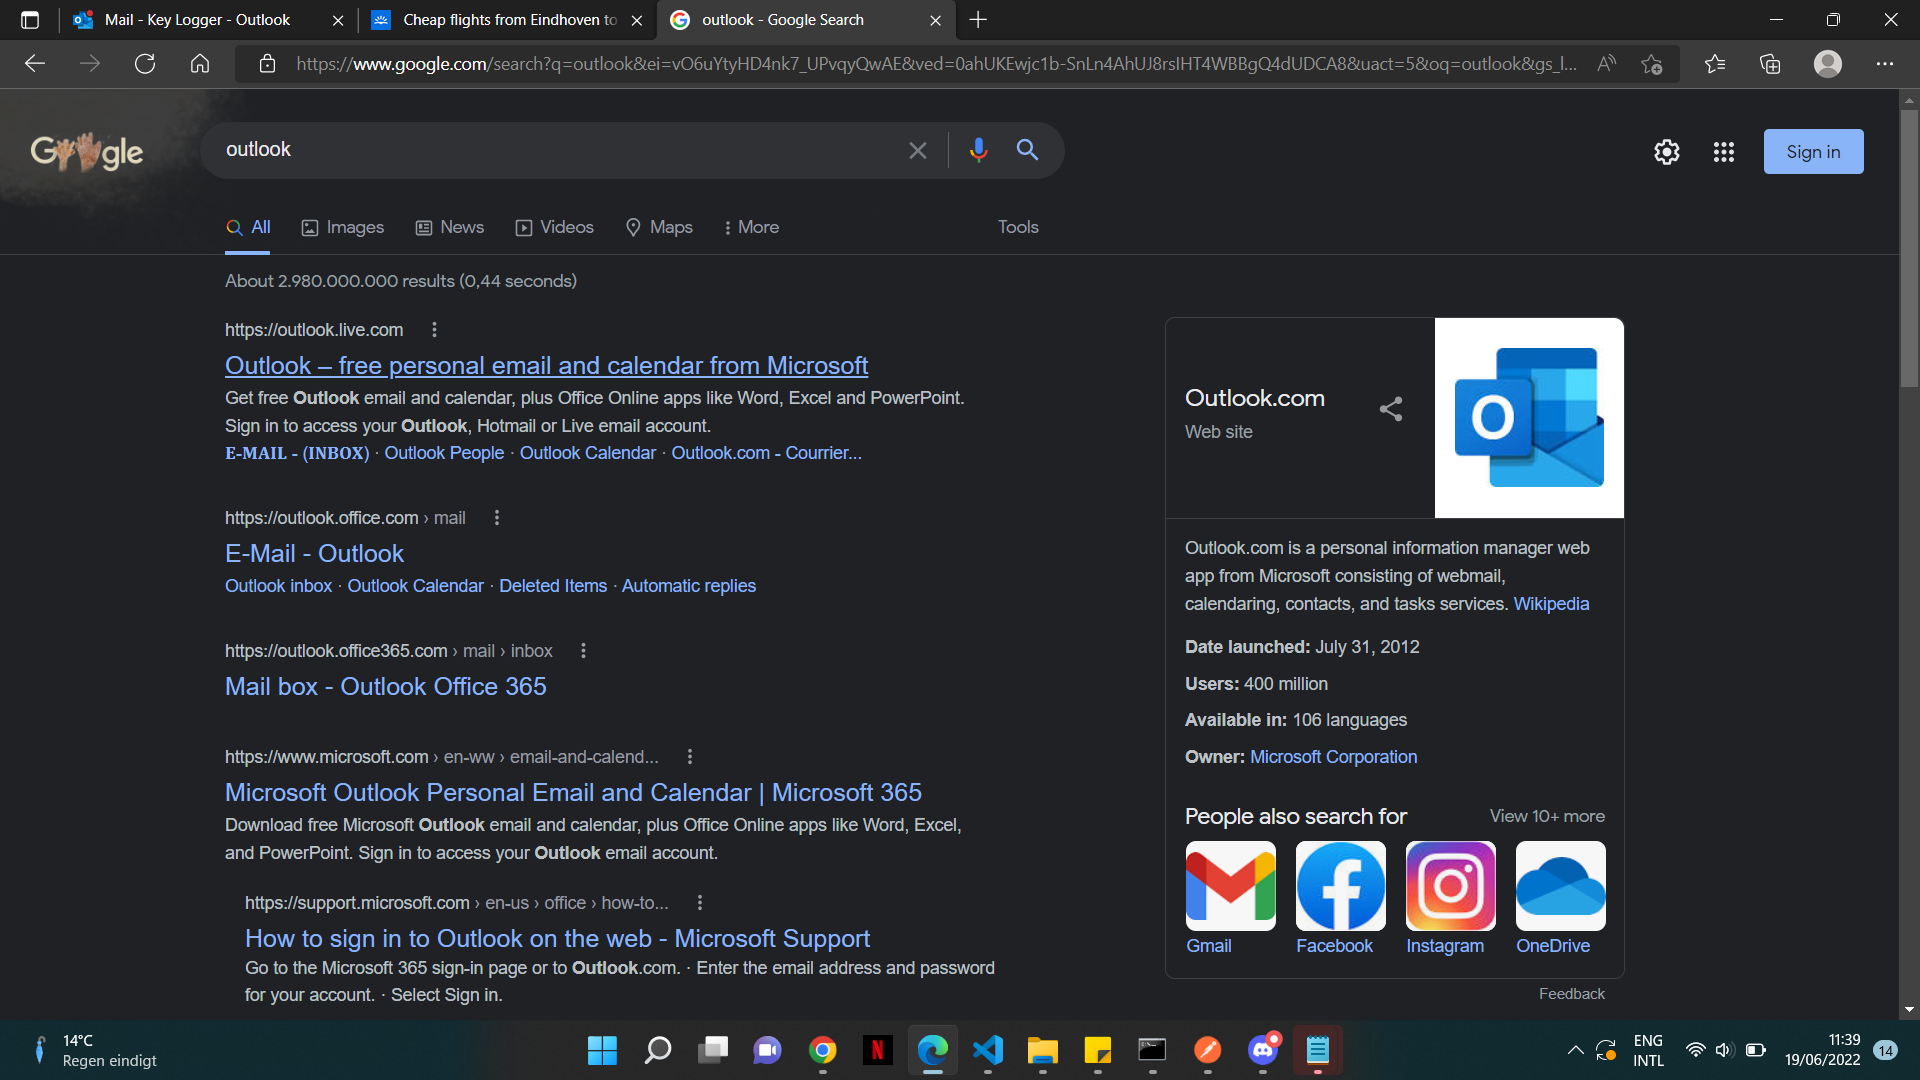

End Image: 2022-06-19-11-39-33.png


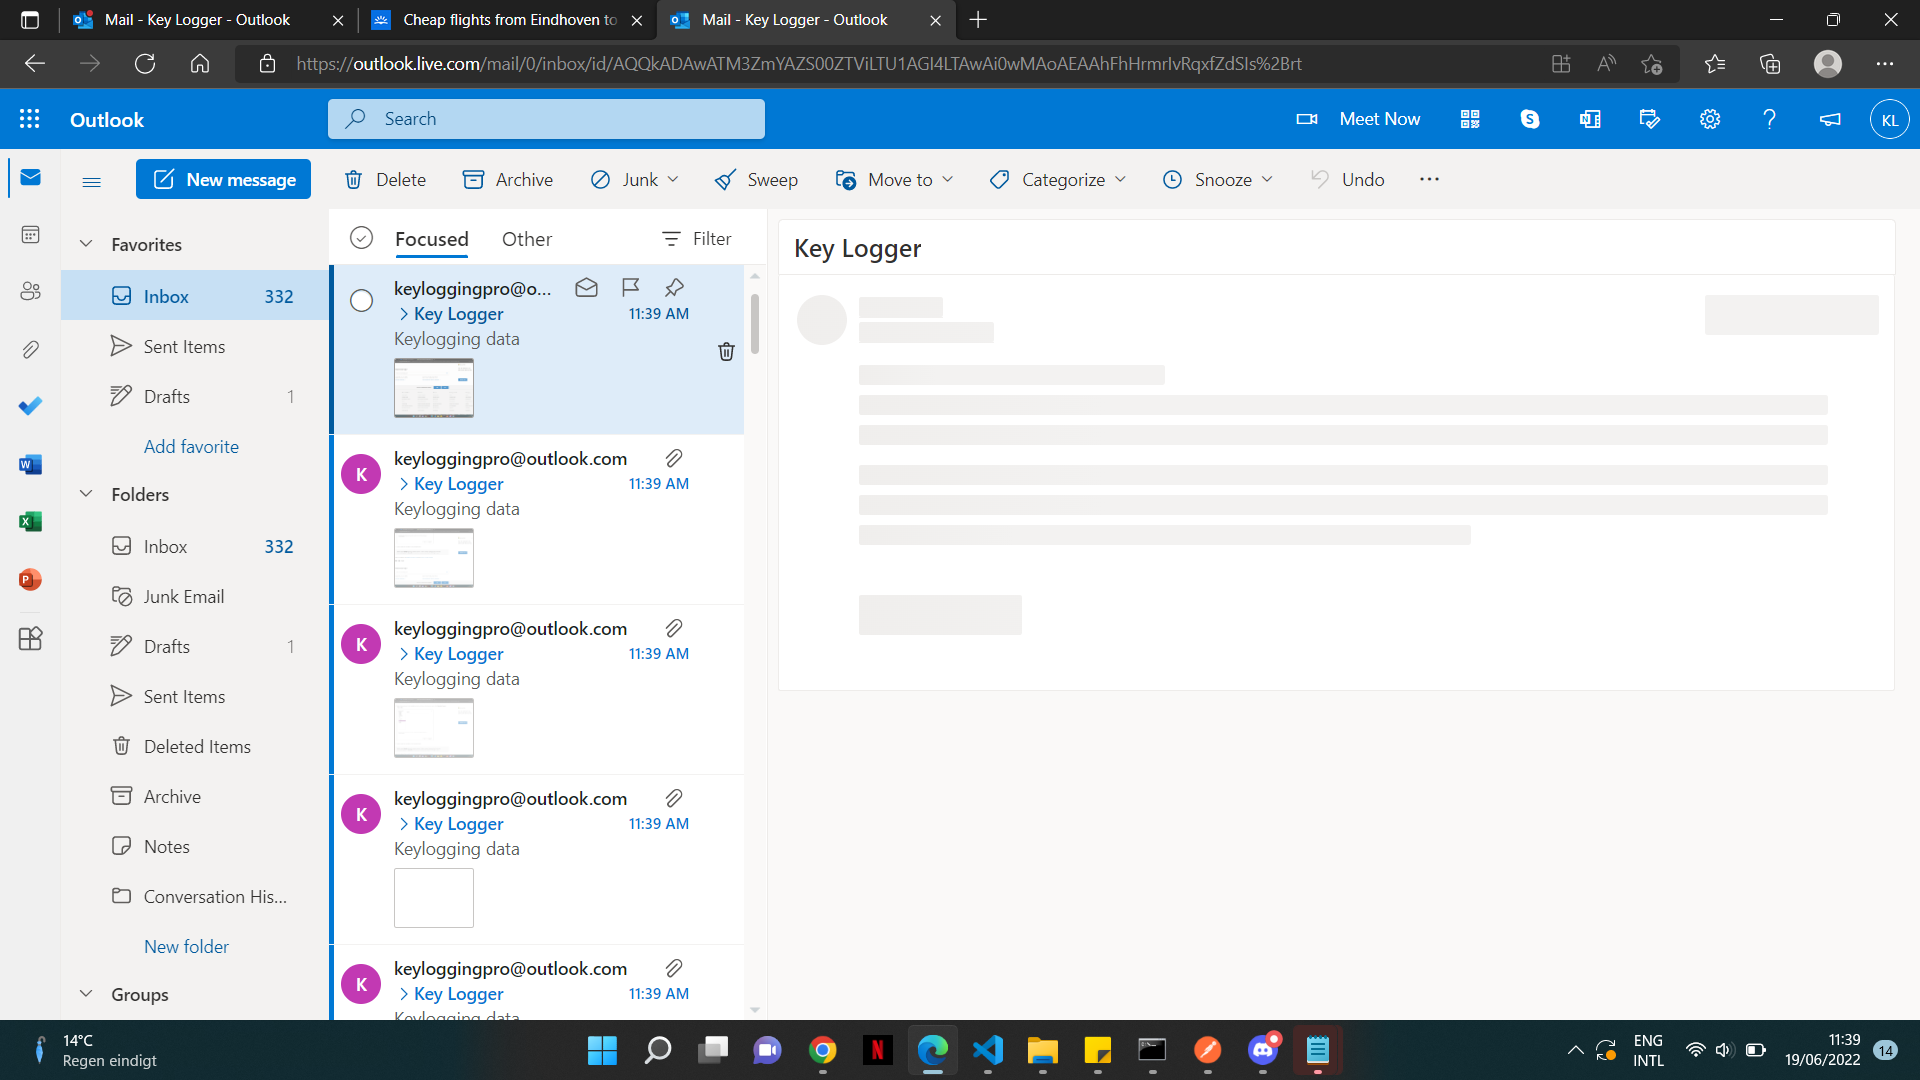

Keystrokes: 
ep l[enter]o
Highlights: 
[]


Timeframe: 2022-06-19-11-39-59 - (...)

Found: Nothing of Interest



In [9]:
# Specify instance name
instance = "instance_1"

# Specify patterns to highlight
patterns = ["currency"]

# Summarize instance with highlighted patterns
summarize(instance, patterns)